# VGG16

In [1]:
import torchvision.models as models
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import shutil
from sklearn.model_selection import train_test_split

In [3]:
from precompute import PrecomputeDataset

In [4]:
# Define the directories for your train and test datasets
train_dir = 'data_/train'
test_dir = 'data_/test'
valid_dir = 'data_/valid'
data_dir = 'data'

# Delete the directories if they exist and then recreate them
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

if os.path.exists(valid_dir):
    shutil.rmtree(valid_dir)
os.makedirs(valid_dir)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg16 = models.vgg16(weights=True)

/home/bard/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
# Get the subdirectories in the original data directory
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for subdir in subdirs:
    print(f"Processing {subdir}...")
    subdir_path = os.path.join(data_dir, subdir)

    # Get a list of all the file names in the subdirectory
    files = os.listdir(subdir_path)
    print(f"Found {len(files)} files.")

    # Split the files into train, test and validation sets
    train_files, test_files = train_test_split(files, test_size=0.3, train_size=0.7 , random_state=42)
    test_files, valid_files = train_test_split(test_files, test_size=0.5, train_size=0.5, random_state=42)

    # Create subdirectories in train, test and validation directories
    train_subdir = os.path.join(train_dir, subdir)
    test_subdir = os.path.join(test_dir, subdir)
    valid_subdir = os.path.join(valid_dir, subdir)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)
    os.makedirs(valid_subdir, exist_ok=True)
    
    # Copy the train files to the train directory
    for file in train_files:
        shutil.copy(os.path.join(subdir_path, file), train_subdir)

    # Copy the test files to the test directory
    for file in test_files:
        shutil.copy(os.path.join(subdir_path, file), test_subdir)

    # Copy the validation files to the validation directory
    for file in valid_files:
        shutil.copy(os.path.join(subdir_path, file), valid_subdir)

    print(f"Copied files for {subdir}.")

Processing fake...
Found 960 files.
Copied files for fake.
Processing real...
Found 1081 files.
Copied files for real.


In [7]:
# Redefine the classifier
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    nn.Dropout(0.5),
    nn.Linear(1000, 2)
)

vgg16 = vgg16.to(device)

In [14]:
vgg16_precomputer = vgg16.features

In [15]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)

In [21]:
#vgg16_precomputer(train_dataset[0][0].to(device)).shape
precomputed_train_dataset = PrecomputeDataset('/precompute', lambda x: (vgg16_precomputer(x[0].to(vgg16_precomputer.get_device())), x[1]), train_dataset)
train_loader = DataLoader(precomputed_train_dataset, batch_size=64, shuffle=True)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, weight_decay=1E-5)

In [ ]:
epochs = 10

for epoch in range(epochs):
	for (img, label) in train_loader:
		optimizer.zero_grad()
		output = classifier(img)
		

In [20]:
def train_one_epoch(model, criterion, optimizer, data_loader, device):
    train_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    return train_loss / len(data_loader.dataset)

def validate(model, criterion, data_loader, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return valid_loss / len(data_loader.dataset), correct / total

def train_model(model, criterion, optimizer, train_dir, transform, valid_loader, device, num_epochs):
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(num_epochs):
        train_dataset = datasets.ImageFolder(train_dir, transform=transform)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        train_loss = train_one_epoch(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = validate(model, criterion, valid_loader, device)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')
    return train_loss_list, valid_loss_list


train_loss_list, valid_loss_list = train_model(vgg16, criterion, optimizer, train_dir, transform_train, valid_loader, device, num_epochs=10)

Epoch 1/10, Train Loss: 14.1496, Valid Loss: 10.6470, Valid Acc: 0.0000


KeyboardInterrupt: 

Test Loss: 0.795353


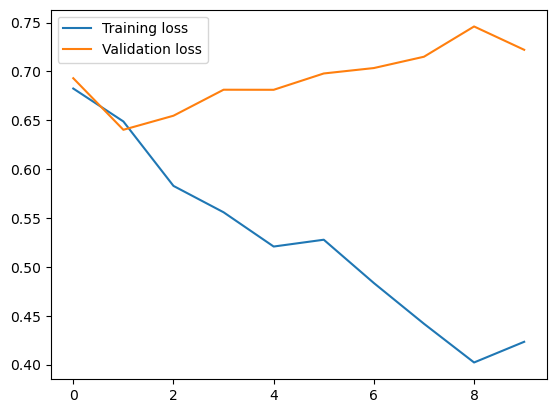

In [13]:
    
# Test
test_loss = 0.0
vgg16.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = vgg16(inputs)
    loss = criterion(output, labels)
    test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}'.format(test_loss))

# Plot the training and validation losses
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend()
plt.show()


In [22]:
# train accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
train_accuracy = 100 * correct / total

print('Accuracy of the network on the {} train images: {} %'.format(len(train_loader.dataset), train_accuracy))

Accuracy of the network on the 1428 train images: 82.8431396484375 %


In [14]:
# test accuracy
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
test_accuracy = 100 * correct / total

print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), test_accuracy))

Accuracy of the network on the 306 test images: 57.51634216308594 %
